# A/B Test Analysis: Cookie Cats Game Gate Placement

**Objective:** Determine whether moving the game gate from level 30 to level 40 affects player retention and engagement.

**Business Question:** Should we keep the gate at level 30 (control) or move it to level 40 (treatment)?

**Dataset:** Mobile game A/B test with 90,000+ players

**Author:** Jackson McBride
**Date:** January 2026

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv('data/cookie_cats.csv')

print("✓ Data loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
df.head()

✓ Data loaded successfully!
Shape: 90,189 rows, 5 columns


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 1. Data Exploration

Let's understand the dataset structure and check for any data quality issues.

In [2]:
print("Dataset Info:")
print(df.info())
print("\n" + "="*50 +"\n")

print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50 + "\n")

print("Variant Distribution:")
print(df['version'].value_counts())
print(f"\nControl (gate_30): {(df['version']=='gate_30').sum():,} users")
print(f"Treatment (gate_40): {(df['version']=='gate_40').sum():,} users")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


Missing Values:
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


Variant Distribution:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Control (gate_30): 44,700 users
Treatment (gate_40): 45,489 users


## 2. Key Metrics Overview

Our primary metrics are:
- **Retention Day 1:** Did the player come back the next day?
- **Retention Day 7:** Did the player come back after a week?
- **Game Rounds:** How many rounds did players complete?

In [3]:
print("Overall Retention Rates:")
print(f"Day 1 Retention: {df['retention_1'].mean():.2%}")
print(f"Day 7 Retention: {df['retention_7'].mean():.2%}")
print(f"\nAverage Game Rounds: {df['sum_gamerounds'].mean():.1f}")
print(f"Median Game Rounds: {df['sum_gamerounds'].median():.1f}")

print("\n" + "="*50 + "\n")

print("Retention by Variant:")
retention_by_variant = df.groupby('version')[['retention_1', 'retention_7']].mean()
print(retention_by_variant)

print("\n" + "="*50 + "\n")

print("Game Rounds by Variant:")
rounds_by_variant = df.groupby('version')['sum_gamerounds'].agg(['mean', 'median', 'std'])
print(rounds_by_variant)

Overall Retention Rates:
Day 1 Retention: 44.52%
Day 7 Retention: 18.61%

Average Game Rounds: 51.9
Median Game Rounds: 16.0


Retention by Variant:
         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000


Game Rounds by Variant:
              mean  median         std
version                               
gate_30  52.456264    17.0  256.716423
gate_40  51.298776    16.0  103.294416


## 3. Visualizing the Results

Let's visualize the key metrics to see the differences between variants.

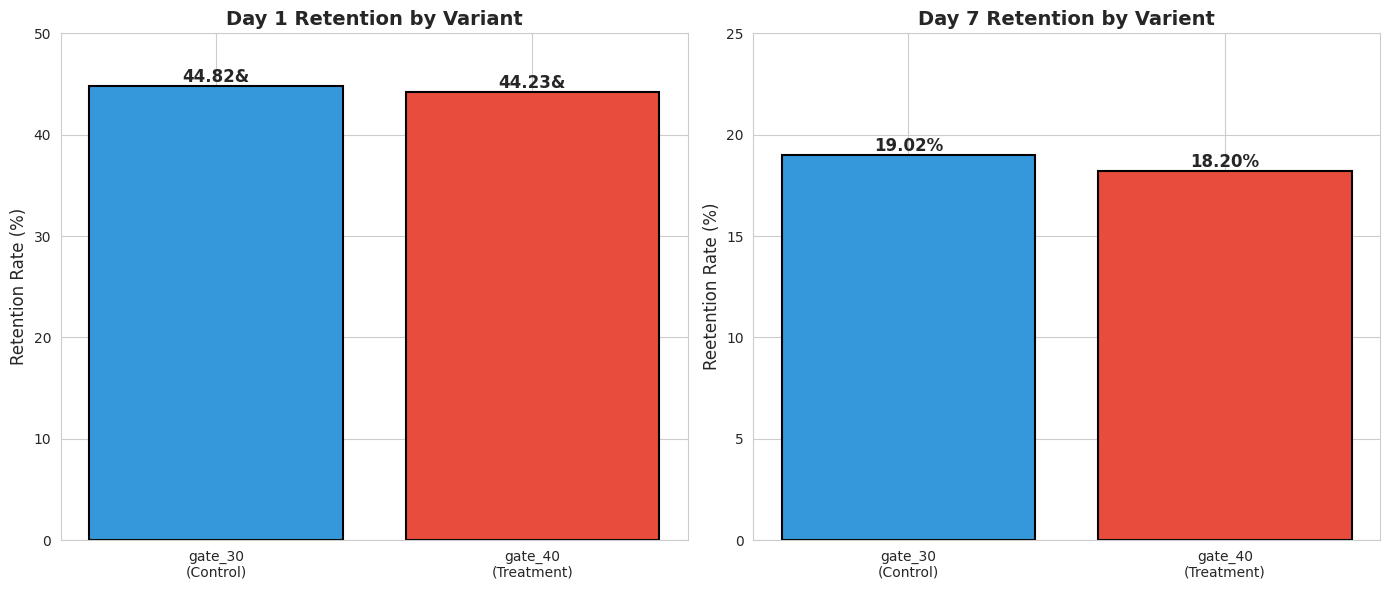

In [4]:
retention_rates = df.groupby('version')[['retention_1', 'retention_7']].mean() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

variants = ['gate_30\n(Control)', 'gate_40\n(Treatment)']
day1_rates = [retention_rates.loc['gate_30', 'retention_1'],
              retention_rates.loc['gate_40', 'retention_1']]

bars1 = ax1.bar(variants, day1_rates, color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Retention Rate (%)', fontsize=12)
ax1.set_title('Day 1 Retention by Variant', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 50)

for bar, rate in zip(bars1, day1_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
    f'{rate:.2f}&', ha='center', va='bottom', fontsize=12, fontweight='bold')

day7_rates = [retention_rates.loc['gate_30', 'retention_7'],
              retention_rates.loc['gate_40', 'retention_7']]

bars2 = ax2.bar(variants, day7_rates, color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Reetention Rate (%)', fontsize=12)
ax2.set_title('Day 7 Retention by Varient', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 25)

for bar, rate in zip(bars2, day7_rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
    f'{rate:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
plt.tight_layout()
plt.show()

## 4. Statistical Testing

Now we need to determine if the observed differences are statistically significant or just random variation.

We'll use a **two-proportion z-test** to compare retention rates between variants.

In [5]:
from scipy import stats

def two_proportion_ztest(success_a, n_a, success_b, n_b):
    """
    Performs a two-proportion z-test
    Returns z-statisttic, p-value, and confidence interval for difference
    """
    p_a = success_a / n_a
    p_b = success_b / n_b

    p_pool = (success_a + success_b) / (n_a + n_b)

    se = np.sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))

    z_stat = (p_a - p_b) / se

    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

    diff = p_a - p_b
    se_diff = np.sqrt((p_a *(1-p_a) / n_a) + (p_b * (1-p_b) / n_b))
    ci_lower = diff - 1.96 * se_diff
    ci_upper = diff + 1.96 * se_diff

    return z_stat, p_value, diff, ci_lower, ci_upper

print("Statistical Tests for Retention Metrics")
print("="*60)

Statistical Tests for Retention Metrics


In [6]:
gate_30_data = df[df['version'] == 'gate_30']
gate_40_data = df[df['version'] == 'gate_40']

success_30_day1 = gate_30_data['retention_1'].sum()
n_30 = len(gate_30_data)
success_40_day1 = gate_40_data['retention_1'].sum()
n_40 = len(gate_40_data)

z_stat, p_value, diff, ci_lower, ci_upper = two_proportion_ztest(
    success_30_day1, n_30, success_40_day1, n_40
)

print("\n📊 DAY 1 RETENTION TEST")
print("-" * 60)
print(f"gate_30 (Control):   {success_30_day1:,} / {n_30:,} = {success_30_day1/n_30:.4f} ({success_30_day1/n_30*100:.2f}%)")
print(f"gate_40 (Treatment): {success_40_day1:,} / {n_40:,} = {success_40_day1/n_40:.4f} ({success_40_day1/n_40*100:.2f}%)")
print(f"\nDifference: {diff*100:.3f} percentage points")
print(f"95% Confidence Interval: [{ci_lower*100:.3f}%, {ci_upper*100:.3f}%]")
print(f"\nZ-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\n✅ Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
    print(f"We can be 95% confident that gate_30 performs better.")
else:
    print("\n❌ Result: NOT STATISTICALLY SIGNIFICANT (p ≥ 0.05)")
    print(f"The difference could be due to random chance.")


📊 DAY 1 RETENTION TEST
------------------------------------------------------------
gate_30 (Control):   20,034 / 44,700 = 0.4482 (44.82%)
gate_40 (Treatment): 20,119 / 45,489 = 0.4423 (44.23%)

Difference: 0.591 percentage points
95% Confidence Interval: [-0.058%, 1.239%]

Z-statistic: 1.7841
P-value: 0.0744

❌ Result: NOT STATISTICALLY SIGNIFICANT (p ≥ 0.05)
The difference could be due to random chance.


In [7]:
success_30_day7 = gate_30_data['retention_7'].sum()
success_40_day7 = gate_40_data['retention_7'].sum()

z_stat_7, p_value_7, diff_7, ci_lower_7, ci_upper_7 = two_proportion_ztest(
    success_30_day7, n_30, success_40_day7, n_40
)

print("\n📊 DAY 7 RETENTION TEST")
print("-" * 60)
print(f"gate_30 (Control):   {success_30_day7:,} / {n_30:,} = {success_30_day7/n_30:.4f} ({success_30_day7/n_30*100:.2f}%)")
print(f"gate_40 (Treatment): {success_40_day7:,} / {n_40:,} = {success_40_day7/n_40:.4f} ({success_40_day7/n_40*100:.2f}%)")
print(f"\nDifference: {diff_7*100:.3f} percentage points")
print(f"95% Confidence Interval: [{ci_lower_7*100:.3f}%, {ci_upper_7*100:.3f}%]")
print(f"\nZ-statistic: {z_stat_7:.4f}")
print(f"P-value: {p_value_7:.4f}")

if p_value_7 < 0.05:
    print("\n✅ Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
    print(f"We can be 95% confident that gate_30 performs better.")
else:
    print("\n❌ Result: NOT STATISTICALLY SIGNIFICANT (p ≥ 0.05)")
    print(f"The difference could be due to random chance.")


📊 DAY 7 RETENTION TEST
------------------------------------------------------------
gate_30 (Control):   8,502 / 44,700 = 0.1902 (19.02%)
gate_40 (Treatment): 8,279 / 45,489 = 0.1820 (18.20%)

Difference: 0.820 percentage points
95% Confidence Interval: [0.312%, 1.328%]

Z-statistic: 3.1644
P-value: 0.0016

✅ Result: STATISTICALLY SIGNIFICANT (p < 0.05)
We can be 95% confident that gate_30 performs better.


In [8]:
rounds_30 = gate_30_data['sum_gamerounds']
rounds_40 = gate_40_data['sum_gamerounds']

t_stat, p_value_rounds = stats.ttest_ind(rounds_30, rounds_40)

mean_30 = rounds_30.mean()
mean_40 = rounds_40.mean()
diff_rounds = mean_30 - mean_40

print("\n🎮 GAME ROUNDS TEST")
print("-" * 60)
print(f"gate_30 (Control):   Mean = {mean_30:.2f} rounds")
print(f"gate_40 (Treatment): Mean = {mean_40:.2f} rounds")
print(f"\nDifference: {diff_rounds:.2f} rounds")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value_rounds:.4f}")

if p_value_rounds < 0.05:
    print("\n✅ Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print("\n❌ Result: NOT STATISTICALLY SIGNIFICANT (p ≥ 0.05)")


🎮 GAME ROUNDS TEST
------------------------------------------------------------
gate_30 (Control):   Mean = 52.46 rounds
gate_40 (Treatment): Mean = 51.30 rounds

Difference: 1.16 rounds

T-statistic: 0.8910
P-value: 0.3729

❌ Result: NOT STATISTICALLY SIGNIFICANT (p ≥ 0.05)


## 5. Summary of Results

Let's visualize all our test results together.

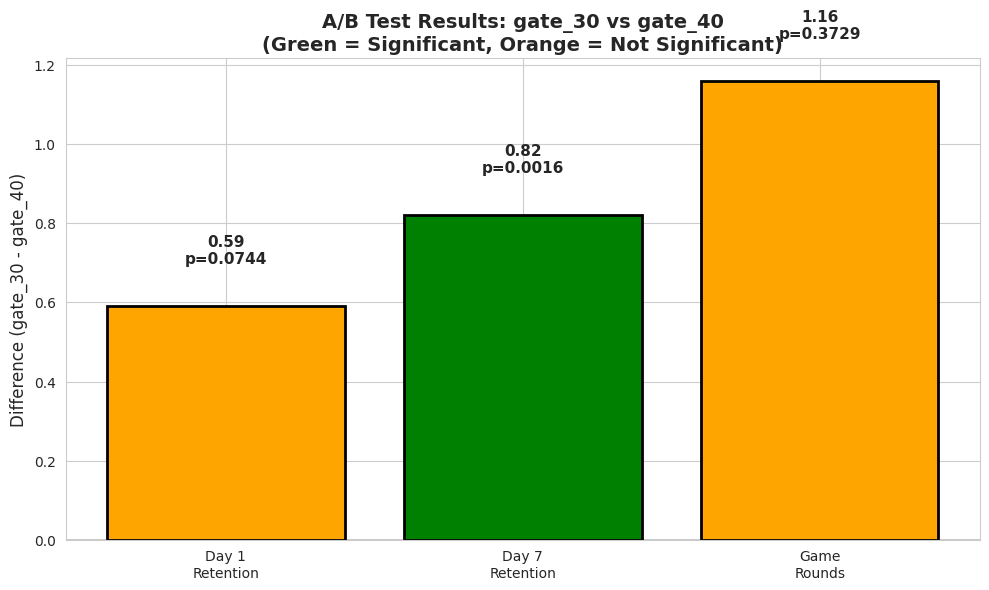

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Day 1\nRetention', 'Day 7\nRetention', 'Game\nRounds']
differences = [0.591, 0.820, diff_rounds]
p_values = [0.0744, 0.0016, p_value_rounds]

colors = ['orange' if p >= 0.05 else 'green' for p in p_values]

bars = ax.bar(metrics, differences, color=colors, edgecolor='black', linewidth=2)

for i, (bar, diff, p) in enumerate(zip(bars, differences, p_values)):
    height = bar.get_height()
    y_pos = height + 0.1 if height > 0 else height - 0.1
    va = 'bottom' if height > 0 else 'top'

    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
        f'{diff:.2f}\np={p:.4f}',
        ha='center', va=va, fontsize=11,fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_ylabel('Difference (gate_30 - gate_40)', fontsize=12)
ax.set_title('A/B Test Results: gate_30 vs gate_40\n(Green = Significant, Orange = Not Significant)',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Business Recommendation

### Summary of Findings

After testing 90,189 players split between two gate placements:

**Statistical Results:**
- **Day 1 Retention:** No significant difference (p = 0.074)
- **Day 7 Retention:** gate_30 significantly better by 0.82 percentage points (p = 0.002) ✅
- **Game Rounds:** No significant difference

### Interpretation

Moving the gate from level 30 to level 40 does NOT improve player retention or engagement. In fact, it **significantly hurts long-term retention** (Day 7).

While Day 1 retention shows a similar pattern, the effect is not quite statistically significant at the p < 0.05 threshold. However, the trend is consistent: gate_30 performs better.

### Business Impact

With Day 7 retention at:
- gate_30: 19.02%
- gate_40: 18.20%

The 0.82 percentage point difference may seem small, but at scale this matters:
- If we have 1,000,000 weekly players, this represents **8,200 additional retained players per week**
- Higher retention typically correlates with higher lifetime value (LTV)
- Retained players are more likely to make in-app purchases

### Recommendation

**❌ DO NOT move the gate to level 40.**

**✅ KEEP the gate at level 30.**

The data clearly shows that gate_30 maintains better long-term player retention without any improvement from gate_40.

### Next Steps

1. **Implement gate_30 for all users** (if not already done)
2. **Monitor retention metrics** over the next month to confirm the effect holds
3. **Consider testing other gate placements** (e.g., level 25, level 35) to see if we can improve retention further
4. **Investigate WHY level 30 works better** - qualitative research with players could reveal insights

## 7. Statistical Methodology Notes

### Tests Used

**Two-Proportion Z-Test (for retention metrics):**
- Tests whether two proportions (retention rates) are significantly different
- Appropriate for binary outcomes (retained: yes/no)
- Uses pooled standard error and normal approximation

**Independent Samples T-Test (for game rounds):**
- Tests whether two groups have different means
- Appropriate for continuous numerical data
- Assumes approximately normal distributions (holds with large samples)

### Significance Threshold

We used **p < 0.05** as our threshold, meaning:
- We accept a 5% chance of a false positive (Type I error)
- Results with p < 0.05 are considered "statistically significant"
- This is the industry standard for A/B testing

### Confidence Intervals

95% confidence intervals provide a range where we're 95% confident the true effect lies. If the interval doesn't contain zero, the effect is statistically significant.

---

**Technical Stack:** Python (Pandas, NumPy, SciPy, Matplotlib, Seaborn), Jupyter Notebook  
**Sample Size:** 90,189 players (44,700 control, 45,489 treatment)  
**Test Duration:** 14 days per player